# NLP Analysis of Segregation in North Carolina

In [1]:
'''
OPTIONAL:
Setting the mood to fit the context of the analysis in a Blues fashion.
'''
from IPython.display import Audio 
Audio('Ray_Charles_-_I_Got_a_Woman_Qoret.com.mp3', autoplay=True)

## Table of Contents

    1 Data and Preprocessing
        1.1 Importing the dependencies
        1.2 Data Processing (re, string manipulation, ...)
        1.3 Pre-processing vs Post-processing
    2 Data Analysis
        2.1 Research question
        2.2 Tools usd
        2.3 NER Analysis of GPE
        2.4 TF-IDF Analysis
        2.5 Topic Models
        2.6 Word Embeddings and PCA
        2.7 Document Embeddings
        2.8 N-Gram Language Models
        2.9 K-Means Clustering and PCA
        2.10 Sentiment Analysis with NLTK's Vader
    3 Visualizations and Comments

## 1. Data and Preprocessing

The data consists of two books about **slavery and segregation** in North Carolina around the 1800's. Specifically, each book contains **transcriptions of full interviews** with the original words of ex-slaves. The latter manuscripts are of course highly interesting to analyze, as they should contain the authentic thoughts of the direct subjects of slavery, yet they're not easy to analyze and read because of the decision of the editors not to translate the dialect and the way they are formatted.

I retrieved these books in .txt format from the library of congress' open source online resources through "Project Gutenberg".

Note: I had to do some simple pre-processing manually to simplify the analysis and make up for the poort structuring of the data. To be precise I eliminated introduction and ending of the editors, and I market the subject of every interview with the tag \<intw>, serving both as an identifier for the name of the person interviewed and for the separation of interviews.

### 1.1 Importing the dependencies

In [2]:
#Importing the necessary dependencies and inizializations
import spacy
import os
from nltk import tokenize
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from nltk import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import plotly.express as px #New library for plotting
import matplotlib.pyplot as plt
from gensim.models import LdaMulticore, TfidfModel, Word2Vec
from gensim.corpora import Dictionary
from gensim.models.word2vec import FAST_VERSION
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Word2Vec
import multiprocessing
from sklearn.utils import shuffle
import re
import string
import random
import nltk
from urllib.request import urlopen
import json
nlp = spacy.load('en_core_web_sm')
stemmer = SnowballStemmer('english')

### 1.2 Data processing

In this section I will process my corpus of interviews into smaller documents in order to explore them and later on carry out my analysis.

**Important** : in my analysis I will focus mainly on **adjectives and nouns** (sometimes considering also verbs), following the literature on the subject <em>"...adjectives are therefore likely to shed light on the nature of what is designated by feeling and emotion, and to illustrate how the two nouns differ in their meaning"</em>, which is the core of this research as I will further explain later in (2). Whereas noun age going to help me best describe the previous everyday life of the ex-slaves in the plantations.

From the psychological research carried out by Beligon (https://journals.openedition.org/lexis/4322).

In [3]:
#Opening the files
files = ['north_carolina2.txt', 'north_carolina1.txt']

In [4]:
#The documents are badly formatted, they do not break sentence-wise, I'll fix that here
documents = [line.strip() for file in files for line in open(file, encoding='utf8').readlines()]

In [5]:
#I can see I have many lines with nothing in them, many '', I'll remove them
documents_no_len0 = [item for item in documents if len(item) != 0]

In [6]:
#I'll now try to unite every sentence, and split it back in documents correctly
documents_united = ' '.join(documents)

In [7]:
#Many sentences have the sequence of characters "\'" which is to highlight the pronounciation of the word.
#Therefore I will not need it for my analysis
documents_no_slash_apostr = documents_united.replace("\'", '')

In [8]:
#Here I will be using regular expressions to:
#1. Break the sentences at the correct points without loss of significance
#2. Substitute some common words that are written in dialect
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Jr|Sr)"
starters = "(Mr|ms|mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(websites, "<prd>\\1", text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    text = text.replace('whus', 'whose')
    text = text.replace('ter', 'there')
    text = text.replace('wuz', 'whose')
    text = text.replace('wid', 'with')
    text = text.replace('wu', 'who')
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

document_cleaned = split_into_sentences(documents_no_slash_apostr)

In [9]:
#Gets all the interviewed people marked with the tag <intw>
interviewed = [d for d in documents if '<intw>' in d]
interviewed_cleaned = [interview[interview.find('>')+1:].capitalize() for interview in interviewed]

In [10]:
#Splitting documents into interviews
document_cleaned_united = ' '.join(document_cleaned)
documents_split_interviews = document_cleaned_united.split('<intw>')
documents_split_interviews.pop(0) #popping an empty list item (the first one)

''

In [11]:
#Here I'm creating a breakpoint at every £ sign to then split the sentences and take the longest one, which is
#the full interview I am interested in.

documents_marked = []
for document in documents_split_interviews:
    res = document.replace('FOOTNOTES', '£')
    res = res.replace('Footnote', '£')
    res = res.replace('District', '£')
    res = res.replace('N.C.', '£')
    res = res.replace('     ', '£')
    res = res.replace('Words:', '£')
    res = res.replace('Editor:', '£')
    res = res.replace('[', '£')
    res = res.replace(']', '£')
    res = res.replace('"','')
    documents_marked.append(max(res.split('£'),key=len))

In [12]:
#Preparation of the future clustering input, separating each interview in a list of sentences
clustering_inp = [split_into_sentences(doc) for doc in  documents_marked]

In [13]:
#There are several lines with the words 'MEMORIES OF ...' followed by '"'', characterized by all capital letters
#I will again exploit the power of regular expression to remove them all.
document_cleaned_upper_intw = []
for document in documents_marked:
    res = re.sub('([A-Z][A-Z\s]*[A-Z])','', document)
    document_cleaned_upper_intw.append(res)

In [14]:
content_interviews = [[token.lemma_ for token in nlp(sentence) if (token.pos_ in ['ADJ','NOUN']) and token.lemma_ != 's'] for sentence in document_cleaned_upper_intw]


In [15]:
#This time I will do the same thing, but instead of the documents being interviews, they will be sentences
document_cleaned_upper = [re.sub('([A-Z][A-Z\s]*[A-Z])','', document) for document in document_cleaned]

In [16]:
#I am now going to remove all references like Footnotes, interviewer names, author's notes, from this sentence-wise array.
#All of the above are fortunately contained in square brackets.
#I'm also removing all double quotes of the kind ".
document_no_authinfos = [document for document in document_cleaned_upper if all(['[' not in document,
                                                                            ']' not in document,
                                                                            'District:' not in document,
                                                                            'Worker:' not in document,
                                                                            'Subject:' not in document,
                                                                            'Words:' not in document,
                                                                            'Writer:' not in document,
                                                                            'Interviewed' not in document,
                                                                            'Editor' not in document,
                                                                            'Date' not in document,
                                                                            'Person' not in document])]
document_no_quotes = [document.replace('"','') for document in document_no_authinfos]

In [17]:
#Removing all leading and trailing spaces with strip
documents_processed= [document.strip() for document in document_no_quotes]

In [18]:
#Begin tokenization
tokens_flat = [token.text for sentence in documents_processed for token in nlp(sentence)]

In [19]:
#Lemmatization and keeping only the content words
lemmas = [[token.lemma_ for token in nlp(sentence) if token.pos_ in ['ADJ','NOUN']] for sentence in documents_processed]


In [20]:
#Processing the future input of my topic model, considering only Adjectives and Noun
topic_m_input = [[token.lemma_ for token in nlp(sentence) if token.pos_ in ['ADJ','NOUN']] for sentence in documents_processed]

In [21]:
#Filters out the empty lists
content_documents_processed = [l for l in lemmas if any(l)]

In [22]:
#Counts the pre-processed token, for plotting purposes to be used later
counts_t = Counter(tokens_flat)
counts_t.items()
df_counts_pre = pd.DataFrame(counts_t.items()).rename(columns={0:'word', 1:'count'}).sort_values('count',ascending=False)

In [23]:
lemmas_flat = [l for lemma in content_documents_processed for l in lemma]

In [24]:
#Counts the post-processed lemmas, for plotting purposes to be used later
counts_l = Counter(lemmas_flat)
counts_l.items()
df_counts_post = pd.DataFrame(counts_l.items()).rename(columns={0:'word', 1:'count'}).sort_values('count',ascending=False)

In [25]:
#For every interview considers only the adjectives
adj_interviews = [[token.lemma_ for token in nlp(sentence) if (token.pos_ =='ADJ') and token.lemma_ != 's'] for sentence in document_cleaned_upper_intw]
adj_interviews_flat = [i for j in adj_interviews for i in j]

In [26]:
#Visualize later the distribution of the most common adjectives in the text
count_adj = Counter(adj_interviews_flat)
count_adj_df = pd.DataFrame(count_adj.most_common(20)).rename(columns={0:'adj',1:'count'})
interviews_tagged_adj = pd.DataFrame(zip(interviewed_cleaned,adj_interviews)).rename(columns={0:'interviewed',1:'text'})

In [27]:
content_interviews_df = pd.DataFrame(zip(interviewed_cleaned, content_interviews)).rename(columns={0:'interviewed',1:'text'})

In [28]:
#Now analyze the verbs and the nouns the same way
verb_interviews = [[token.lemma_ for token in nlp(sentence) if (token.pos_ =='VERB') and token.lemma_ != 's'] for sentence in document_cleaned_upper_intw]
verb_interviews_flat = [i for j in verb_interviews for i in j]

count_verb = Counter(verb_interviews_flat)
count_verb_df = pd.DataFrame(count_verb.most_common(20)).rename(columns={0:'verb',1:'count'})

In [29]:
noun_interviews = [[token.lemma_ for token in nlp(sentence) if (token.pos_ =='NOUN') and token.lemma_ != 's'] for sentence in document_cleaned_upper_intw]
noun_interviews_flat = [i for j in noun_interviews for i in j]

count_noun = Counter(noun_interviews_flat)
count_noun_df = pd.DataFrame(count_noun.most_common(20)).rename(columns={0:'noun',1:'count'})

### 1.3 Pre-processing vs Post-processing

In [30]:
print(f'Total number of pre-processed tokens: {len(tokens_flat)}')

Total number of pre-processed tokens: 183983


In [31]:
print(f'Total number of post-processed tokens: {len(lemmas_flat)}')

Total number of post-processed tokens: 36405


In [32]:
print(f'Average number of nouns/adjectives per interview: {round(np.mean([len(l) for l in content_interviews]),2)}')

Average number of nouns/adjectives per interview: 178.28


In [33]:
print(f'Average number of documents (sentences) per interview: {round(np.mean([len(l) for l in clustering_inp]),2)}')

Average number of documents (sentences) per interview: 54.07


In [34]:
print(f'Number of ex-slave names: {len(interviewed_cleaned)}')

Number of ex-slave names: 175


In [35]:
print(f'The total number of interviews in the books is {len(interviewed)}')

The total number of interviews in the books is 175


In [36]:
print(f'Total number of pre-processed documents: {len(split_into_sentences(documents_no_slash_apostr))}')

Total number of pre-processed documents: 11765


In [37]:
print(f'Total number of post-processed documents: {len(documents_processed)}')

Total number of post-processed documents: 11107


## 2. Analysis and Visualization


### 2.1 Research question
This reaserch aims at investigating the phenomena of segregation in North Carolina as a whole. In particular, the focus will be diverted towards investigating the living conditions of the slaves, to understand their reality, and study their thoughts and feelings. Furthermore, the research will aim at retrieving information to possibly reconstruct geographically the Counties in the state most subject to segregation, so that to map the most "segregated" ones.

### 2.2 Tools used

* <strong>Word embeddings</strong>
* <strong>Document embeddings</strong>
* <strong>TFIDF analysis</strong>
* <strong>Topic models</strong>
* <strong>Dimensionality reduction</strong>
* <strong>K-Means Clustering</strong>
* <strong>N-gram Language models</strong>
* <strong>Sentiment Analysis with NLTK's VADER</strong>

Choices of clusters in K-Means will be backed by using the elbow rule, and most dimensionality choices for PCA will be such that they allow for a clear visualization and approximation of the majority of the information contained in the data.

My analysis will be then run on around **12,000** preprocessed documents. Although once in my analysis I will allow myself to change the definition of "documents", from them being (usually) sentences within interviews, to being full interviews.

### 2.3 NER analysis of GPE

In [38]:
#GeoPoliticalEntities - GPE
#I'll begin with looking at the cities mentioned in the document, and I am going to assume they are a representative 
#Sample of proportion of slaves per each city. I will then plot everything using plotly.
cities = [entity.text for sentence in documents_processed for entity in nlp(sentence).ents if entity.label_ == "GPE"]
cities_counted = Counter(cities)

In [39]:
#Loading the csv and xls datasets containing information about north carolina counties
nc_counties = pd.read_csv('NC_Counties.csv')
fips_counties = pd.read_excel('US_FIPS_Codes.xls')

In [40]:
fips_counties.columns = fips_counties.iloc[0,:]
fips_counties = fips_counties.drop(0).reset_index(drop=True)
nc_counties_fips = fips_counties[fips_counties['State']=='North Carolina']
nc_counties['CO_NAME'] = nc_counties['CO_NAME'].str.capitalize()
full_df_counties_fips = pd.merge(nc_counties_fips, nc_counties, left_on='County Name', right_on='CO_NAME')
full_df_counties_fips['County Name'] = full_df_counties_fips['County Name'].apply(lambda x : x + ' County')
full_df_counties_fips['fips'] = full_df_counties_fips['FIPS State'] + full_df_counties_fips['FIPS County']
df_counties = pd.DataFrame([(key,val) for key,val in dict(cities_counted).items()]).rename(columns={0:'county', 1:'count'})
df_counties = df_counties[df_counties['county'].str.contains('County')]

In [41]:
#Look at the length of the set intersection between the two to see how many are present
counties_mentioned = np.intersect1d(full_df_counties_fips['County Name'], df_counties['county'])
print(f'{round((len(counties_mentioned)/len(full_df_counties_fips)),2)*100}% of the counties in North Carolina are mentioned in the documents')
#Prepare df, which has columns with (count, fips)
df_fips_count = pd.merge(df_counties, full_df_counties_fips, left_on='county', right_on='County Name')[['count','fips','county']]


45.0% of the counties in North Carolina are mentioned in the documents


In [42]:
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)
nc_data = [item for item in counties['features'] if item['properties']['STATE'] == '37']
counties['features'] = nc_data

### 2.4 TF-IDF Analysis

In [43]:
#Joins every document with a space in between, useful for tfidf
content_documents_processed_united = [' '.join(l) for l in content_documents_processed]

In [44]:
#Setting up TF-IDF's parameters and creating the model for all content words
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                  min_df=0.001,
                                  max_df=0.75,
                                  stop_words='english',
                                  sublinear_tf=True)
#NO, USE CONTENT WORDS
X_raw = tfidf_vectorizer.fit_transform(content_documents_processed_united)
X = pd.DataFrame({
    'tf_idf':X_raw.sum(axis=0).A1,
    'idf':tfidf_vectorizer.idf_,
    'words':list(tfidf_vectorizer.vocabulary_.keys())
                })

In [45]:
#Sorting the values in descending order, we will need this for a nice plot
X_sorted = X.sort_values('tf_idf', ascending=False).reset_index(drop=True)
X_sorted.head()
X_sorted['plot_size'] = np.sqrt(X_sorted['tf_idf'])

In [46]:
#Do a second TF-IDF just for the ADJ words - NOW I WILL CONSIDER interviews as documents
tfidf_vectorizer_adj = TfidfVectorizer(analyzer='word',
                                  min_df=0.001,
                                  max_df=0.75,
                                  stop_words='english',
                                  sublinear_tf=True)

X_raw_adj = tfidf_vectorizer_adj.fit_transform([' '.join(i) for i in adj_interviews])

X_adj = pd.DataFrame({
    'tf_idf':X_raw_adj.sum(axis=0).A1,
    'idf':tfidf_vectorizer_adj.idf_,
    'words':list(tfidf_vectorizer_adj.vocabulary_.keys())
                })
X_sorted_adj = X_adj.sort_values('tf_idf', ascending=False).reset_index(drop=True)
X_sorted_adj.head()
X_sorted_adj['plot_size'] = np.sqrt(X_sorted['tf_idf'])

### 2.5 Topic Models

In [47]:
#Creating the inputs with content words
dictionary = Dictionary(content_documents_processed)#topic_m_input
dictionary.filter_extremes(no_below=60,no_above=0.1)
dictionary.filter_extremes()
ldacorpus = [dictionary.doc2bow(text) for text in content_documents_processed]
tfidfmodel = TfidfModel(ldacorpus)
model_corpus = tfidfmodel[ldacorpus]
len(model_corpus)

10057

In [48]:
#Creating the model
num_passes=12
num_topics=5
chunk_size=len(model_corpus) + num_passes/170
model = LdaMulticore(model_corpus,
                    id2word=dictionary,
                    num_topics=num_topics,
                    workers=min(10,multiprocessing.cpu_count()-1),
                    passes=num_passes,
                    chunksize=chunk_size)

In [49]:
#Identifying the most relevant topics, chosen to be 5 since I do not expect a huge variability in topics
topic_corpus = model[model_corpus]
topic_sep = re.compile(r"0\.[0-9]{3}\*")
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split('+ ')) for topic_no, model_topic in model.print_topics(num_topics=num_topics, num_words=5)]
topic_models_output = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:5]))
    topic_models_output.append([", ".join(m[:5]).replace('"', '')])

1 "white" , "folk" , "place" , "little" , "night"
2 "time" , "father" , "war" , "nigger" , "dat"
3 "slave" , "good" , "bout" , "free" , "case"
4 "mother" , "house" , "man" , "big" , "marsthere"
5 "year" , "day" , "plantation" , "dey" , "old"


### 2.6 Word Embeddings & PCA

In [50]:
#As an input give only ADJ and NOUN

In [51]:
# Here I will initialize model
w2v_model = Word2Vec(size=100, # vector size
                     window=15, # window for sampling
                     sample=0.0001, # subsampling rate
                     iter=200, # iterations
                     negative=5, # negative samples
                     min_count=1, # minimum threshold
                     workers=-1, # parallelize to all cores
                     hs=0, # no hierarchical softmax
                     seed = 1
)

# build the vocabulary
w2v_model.build_vocab(content_documents_processed) #content_documents_processed

# train the model
w2v_model.train(content_documents_processed, #content_documents_processed
                total_examples=w2v_model.corpus_count, 
                epochs=w2v_model.epochs)

(0, 0)

In [52]:
#I will make use of PCA in order to plot the data reducing it to its 2 most important components
from sklearn.decomposition import PCA
def display_pca_scatterplot_w2v(model, words, vals,sample=0):
    
    word_vectors = np.array([model[w] for w in words])
    print(len(word_vectors))
    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    fig, ax = plt.subplots(figsize=(15,10))
    
    sns.scatterplot(x=twodim[:,0],
                    y=twodim[:,1],
                    palette=sns.dark_palette("#69d", reverse=True, as_cmap=True),
                    hue=vals,
                    size=vals,
                    sizes=(2, 2000),
                    ax=ax)
    offset_x=0.0007
    offset_y=0.002
    for word, t in zip(words, twodim):
        plt.annotate(word, (t[0]+offset_x,t[1]-offset_y), fontsize=12)
    plt.axis('off')

### 2.7 Document Embeddings

In [53]:
#We consider just the abjectives and nouns here
#Get the average number of lemmas composing texts
content_interviews_df['length'] = content_interviews_df['text'].apply(lambda x: len(x))
content_interviews_df.describe()

length
count  175.000000
mean   178.280000
std     93.185185
min     26.000000
25%    113.500000
50%    158.000000
75%    221.000000
max    524.000000

In [54]:
# create a list of TaggedDocument objects
corpus = []

for label, text in zip(content_interviews_df.interviewed, content_interviews_df.text):
    corpus.append(TaggedDocument(words=text, 
                                 tags=[str(label)]))

print('done')
# initialize model
d2v_model = Doc2Vec(vector_size=110, 
                    window=40,
                    hs=0,
                    sample=0.000001,
                    negative=5,
                    min_count=3,
                    workers=-1,
                    epochs=500,
                    dm=0, 
                    dbow_words=1)

# build the vocabulary
d2v_model.build_vocab(corpus)

# train the model
d2v_model.train(corpus, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

done


In [55]:
doc2vec_output_top5 = [d2v_model.wv.most_similar([d2v_model.docvecs[person]], topn = 25) for person in content_interviews_df.interviewed.values]
doc2vec_output_top5_flat_words = [i[0] for s in doc2vec_output_top5 for i in s]
counts_d2v = Counter(doc2vec_output_top5_flat_words)
print(f'Unique characterizing words: {len(counts_d2v)}')
plot_doc2vec = pd.DataFrame(counts_d2v.most_common(30)).rename(columns={0:'word',1:'count'})

Unique characterizing words: 1345


In [56]:
#For each person interviewed consider only content words ADJ, NOUN, VERB
#Create a dataset with as many columns as unique words in the output of doc2vec
corr_df_d2v = pd.DataFrame(columns=counts_d2v.keys())
word_present = [[w[0] for w in d] for d in doc2vec_output_top5]
for idx,word in enumerate(word_present):
    corr_df_d2v.loc[len(corr_df_d2v)] = 0
    corr_df_d2v.iloc[idx,:] = corr_df_d2v.iloc[idx,:][word] +1

In [57]:
#Many NaN values are created, now I will replace all of them with a zero
corr_df_d2v.fillna(0,inplace=True)

### 2.8 N-gram Language models

In [58]:
random.seed(30)
smoothing = 0.0001
START = '_***_'
STOP = '_STOP_'
n_grams = 4

In [59]:
counts = defaultdict(lambda: defaultdict(lambda: smoothing))
letters = tuple([random.choice(string.ascii_letters) for i in range(n_grams)])
for sentence in documents_processed:
    # include special tokens for start and the end of sentence
    tokens = [START for i in range(n_grams-1)] + sentence.split() + [STOP]
    for letters in nltk.ngrams(tokens, n_grams):
        counts[tuple(letters[:-1])][letters[-1]] += 1
def sample_next_word(cond=tuple()):
    """
    sample a word w based on the history (u, v)
    """
    # separate word and their counts into separate variables
    keys, values = zip(*counts[cond].items())
    values = np.array(values)
    values /= values.sum() # create probability distro
    
    # this is the meat of the function
    sample = np.random.multinomial(1, values) # pick one position

    return keys[np.argmax(sample)]

def g_sent(i=[],n_grams=4):
    i = i.split() if i else i
    result = [START for i in range(n_grams-1)] + i
    for j in range((len(i)+1)):
        try:
            next_word = sample_next_word(tuple([result[n-j] for n in range((-(n_grams-1)),0)]))
        except ValueError:
            pass
    
    result.append(next_word)
    c = n_grams
    while next_word != STOP:
        c -= 1
        if c-1 > 0:
            try:
                next_word = sample_next_word(tuple([result[n] for n in range((-(n_grams-1)),0)]))
            except ValueError:
                next_word = sample_next_word(tuple([START for i in range(c-1)])+tuple([result[n] for n in range(-(n_grams-c),0)]))
            result.append(next_word)
        else:     
            next_word = sample_next_word(tuple([result[n] for n in range((-(n_grams-1)),0)]))
            result.append(next_word)
    return ' '.join(result[n_grams-1:-1])



In [60]:
print(g_sent('I wus just five years ole',n_grams))

I wus just five years ole De nigger made de crap sold it an we moved there Wake County, out near Wendell an when I whos a married oman way fore de war.


In [61]:
print(g_sent('I was born a slave',n_grams))

I was born a slave I had nothin on me, no responsibility on any of us, only to work.


In [62]:
print(g_sent('My older sister took me',n_grams))

My older sister took me Us dakies didn know whut to do.


In [63]:
print(g_sent('The plantation was very large',n_grams))

The plantation was very large That was called the silk stockin church.


In [64]:
print(g_sent('There were about one hundred',n_grams))

There were about one hundred One was my pappys sisthere.


### 2.9 Clustering 

In [65]:
cluster_input = []
for key,val in enumerate(clustering_inp):
    for item in val:
        cluster_input.append((interviewed_cleaned[key], [t.lemma_ for t in nlp(item) if t.pos_ in ['ADJ','NOUN','VERB']]))

In [66]:
cluster_input = pd.DataFrame(cluster_input).rename(columns={0:'label',1:'item'})

In [67]:
cluster_input = shuffle(cluster_input)

In [68]:
#use count_vectorize
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_cluster = TfidfVectorizer(ngram_range=(1,2), 
                             min_df=0.001, 
                             max_df=0.7, 
                             analyzer='word',
                             sublinear_tf=True
                            )
X = vectorizer_cluster.fit_transform([' '.join(i) for i in cluster_input['item'].values]).toarray()
y = cluster_input['label']

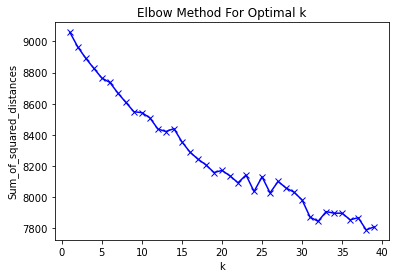

In [69]:
'''
! WARNING !
Takes a couple of minutes to run, it is going to plot the elbow rule plot for the decision
of the number of clusters to be utilized in the analysis. 
The elbow is not particularly curved, but I have found a good number to be 22.
I will implement it manually in the next line.'''

#Choosing the best K (number of clusters) with the Elbow Rule
Sum_of_squared_distances = []
K = range(1,40)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()
#Approximately 25

In [70]:
#Use the same stuff you used above
km = KMeans(n_clusters=25, n_jobs=-1)
clusters = km.fit_predict(X)
centroids = km.cluster_centers_

/Users/niccolodiana/opt/anaconda3/envs/nlp_slavery/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


In [71]:
def display_pca_scatterplot(vals,y,sample=0):
    
    twodim = PCA(2).fit_transform(vals)
    
    fig, ax = plt.subplots(figsize=(15,8))
    
    sns.scatterplot(x=twodim[:,0],
                    y=twodim[:,1],
                    palette=sns.dark_palette("#69d", reverse=True, as_cmap=True),
                    hue=clusters,
                    ax=ax)

### 2.10 Sentiment Analysis

In [72]:
nltk.download([
     "vader_lexicon"
 ])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/niccolodiana/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [73]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [74]:
neg = []
pos = []
neu = []
for lista in clustering_inp:
    for sentence in lista:
        res = sia.polarity_scores(sentence)
        neg.append(res['neg'])
        pos.append(res['pos'])
        neu.append(res['neu'])

In [75]:
print(f'Negative sum: {round(sum(neg),2)}, Positive sum: {round(sum(pos),2)}, Neutral sum: {round(sum(neu),2)}')

Negative sum: 591.22, Positive sum: 503.51, Neutral sum: 8366.29


## 3 Visualization and comments

Text(0.5, 1.0, 'Zipf distribution of the tokens count (post-processed)')

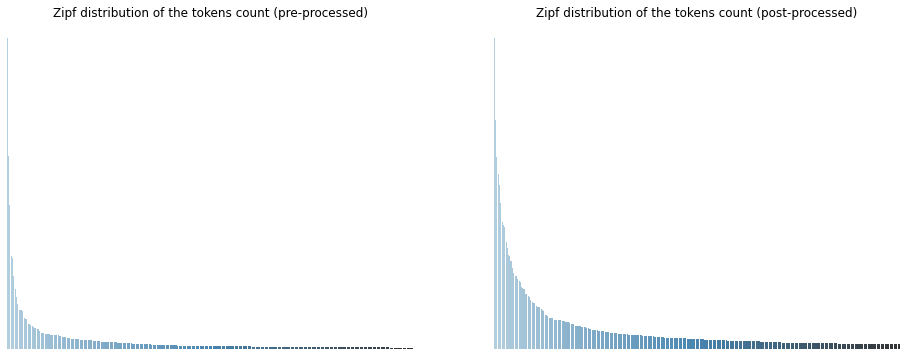

In [76]:
#ZIPS DISTRIBUTION PRE PROCESSED TOKENS
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
sns.barplot(data = df_counts_pre.iloc[:500,:], x='word',y='count',palette='Blues_d',ax=ax1)
ax2 = sns.barplot(data = df_counts_post.iloc[:500,:], x='word',y='count',palette='Blues_d',ax=ax2)
ax2.axis('off')
ax1.axis('off')
ax1.set_title('Zipf distribution of the tokens count (pre-processed)')
ax2.set_title('Zipf distribution of the tokens count (post-processed)')

**Comment**: We can see a smoothing of the Zipf distribution after processing the documents, since we have eliminated punctuation and other stuff, keeping only ADJs and NOUNs.

Text(0.5, 1.0, 'Count of the tokens/lemmas pre and post processing')

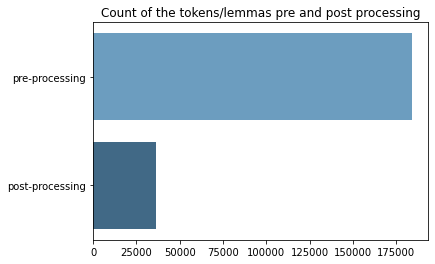

In [77]:
fig, ax = plt.subplots()
sns.barplot(x=[len(tokens_flat),len(lemmas_flat)],y=['pre-processing', 'post-processing'],palette='Blues_d',ax=ax)
ax.set_title('Count of the tokens/lemmas pre and post processing')

Text(0.5, 1.0, 'Number of document sentences vs document interviews')

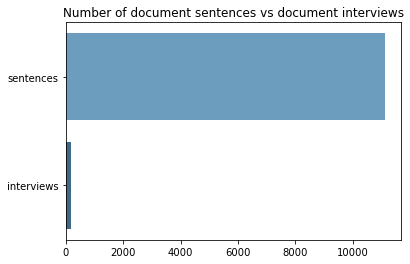

In [78]:
#We can see the difference of the two arrays: when the documents are "sentences" vs when they're full "interviews"
fig, ax = plt.subplots()
sns.barplot(y=['sentences','interviews'], x=[len(documents_processed), len(documents_marked)], palette='Blues_d',ax=ax)
ax.set_title('Number of document sentences vs document interviews')

Text(0.5, 1.0, 'Counts of the adjectives throughout the corpus')

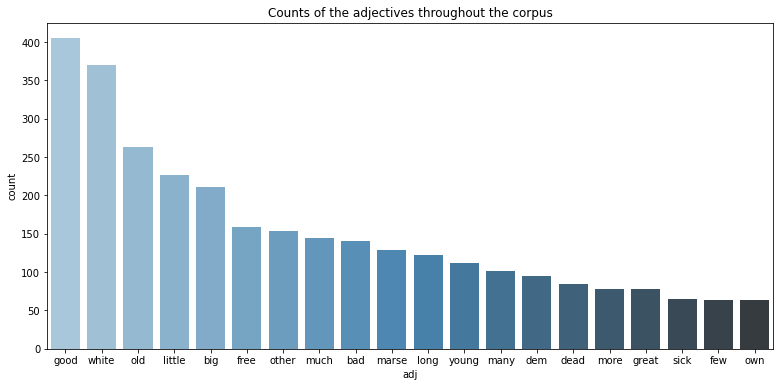

In [79]:
fig, ax = plt.subplots(figsize=(13,6))
sns.barplot(data=count_adj_df, x='adj',y='count',palette="Blues_d",ax=ax)
ax.set_title('Counts of the adjectives throughout the corpus')

Text(0.5, 1.0, 'Counts of the noun throughout the corpus')

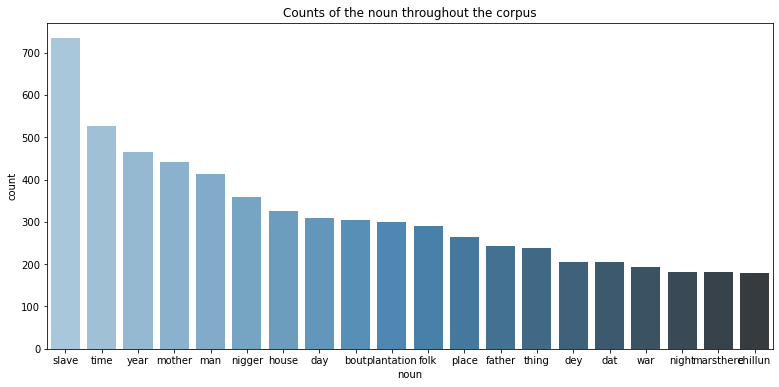

In [80]:
fig, ax = plt.subplots(figsize=(13,6))
sns.barplot(data=count_noun_df, x='noun',y='count',palette="Blues_d",ax=ax)
ax.set_title('Counts of the noun throughout the corpus')

Text(0.5, 1.0, 'Counts of the verbs throughout the corpus')

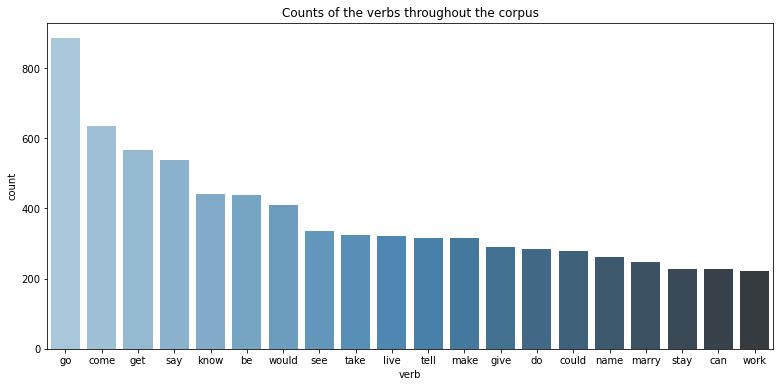

In [81]:
fig, ax = plt.subplots(figsize=(13,6))
sns.barplot(data=count_verb_df, x='verb',y='count',palette="Blues_d",ax=ax)
ax.set_title('Counts of the verbs throughout the corpus')

### ! Really Cool ! Geographical plot of the Counties in N.C. with number of mentions

In [82]:
colorscale = [
    'rgb(100,151,177)',#light blue
    'rgb(0,91,150)',#darker
    'rgb(3,57,108)',
    'rgb(1,31,75)',
    'rgb(1,20,55)',
    'rgb(1,13,38)',
    'rgb(2,2,2)'#darkest
]

#Custom the color scale with a range of reds later on.
fig = px.choropleth(df_fips_count,
                    geojson=counties, 
                    locations='fips', 
                    color='count',
                    color_continuous_scale=colorscale,
                    range_color=(0, 12),
                    scope="usa",
                    hover_data=["county", "count", "fips"])

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_geos(fitbounds="locations")
fig.show()

**Comment**: I am plotting geographically the Counties in N.C. where the hue represents their number of mentions in the documents. If we assume the count of occurrences of each County name in the documents to be fairly close to a true representation of the distribution of ex-slaves in the State, we get a powerful heatmap reconstructing historically the most and least segregated counties in the State.

Results match a first glance superficial analysis by giving a larger count (darker color) around the Counties where the capital of the State is located.

### Plotting the Tf-Idf output in 2D of the (NOUN, ADJ) and only (ADJ)

Text(0.5, 1.0, 'tf & TF-IDF Plot on content words (NOUN/ADJ/VERB)')

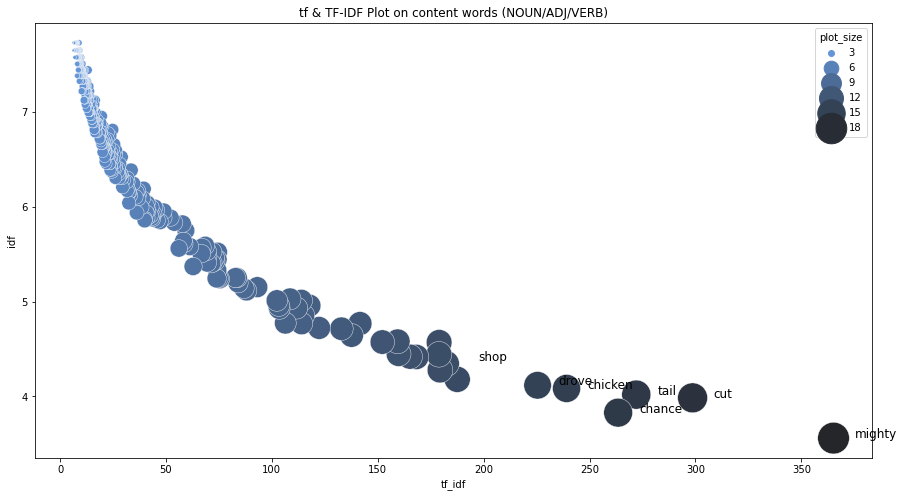

In [83]:
#Plots idf against tfidf, add the words for each bubble 
fig, ax = plt.subplots(figsize=(15,8))
sns.scatterplot(data = X_sorted, 
                x='tf_idf',
                y='idf',
                size='plot_size',
                sizes=(2, 1000), 
                ax=ax,
                hue='plot_size',
                palette=sns.dark_palette("#69d", reverse=True, as_cmap=True))
for i, word in enumerate(X_sorted['words'][:7]):
    if i == 6:
        distance=.2
    else:
        distance = 0
    plt.annotate(word, (X_sorted['tf_idf'][i]+10, X_sorted['idf'][i]+distance),fontsize=12)
ax.set_title('tf & TF-IDF Plot on content words (NOUN/ADJ/VERB)')

Text(0.5, 1.0, 'tf & TF-IDF Plot on ADJ')

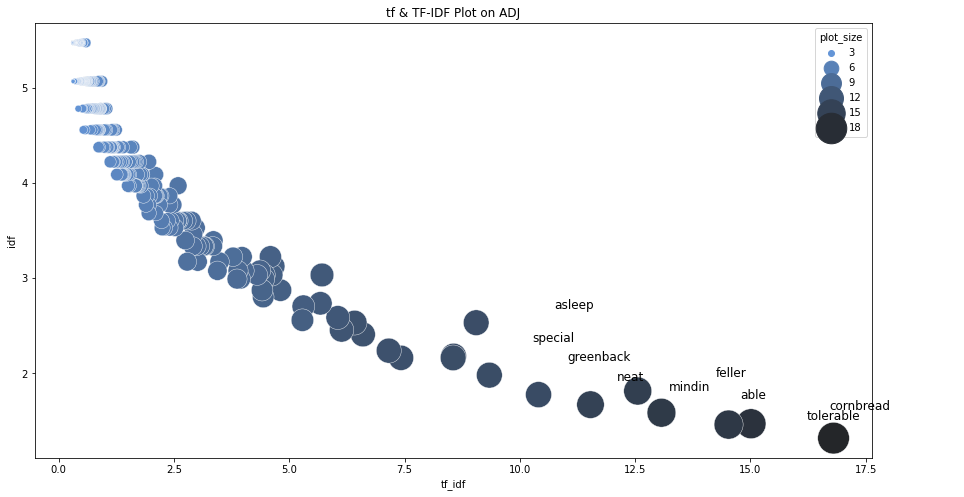

In [84]:
fig, ax = plt.subplots(figsize=(15,8))
sns.scatterplot(data = X_sorted_adj, 
                x='tf_idf',
                y='idf',
                size='plot_size',
                sizes=(2, 1000), 
                ax=ax,
                hue='plot_size',
                palette=sns.dark_palette("#69d", reverse=True, as_cmap=True))
for i, word in enumerate(X_sorted_adj['words'][:10]):
    if i == 2:
        distance=.05
    else:
        distance = .15
    plt.annotate(word, (X_sorted_adj['tf_idf'][i]+1.7, X_sorted_adj['idf'][i]+distance),fontsize=12)
    
ax.set_title('tf & TF-IDF Plot on ADJ')

### Using the output of the topic models as input to the word2vec with PCA

30


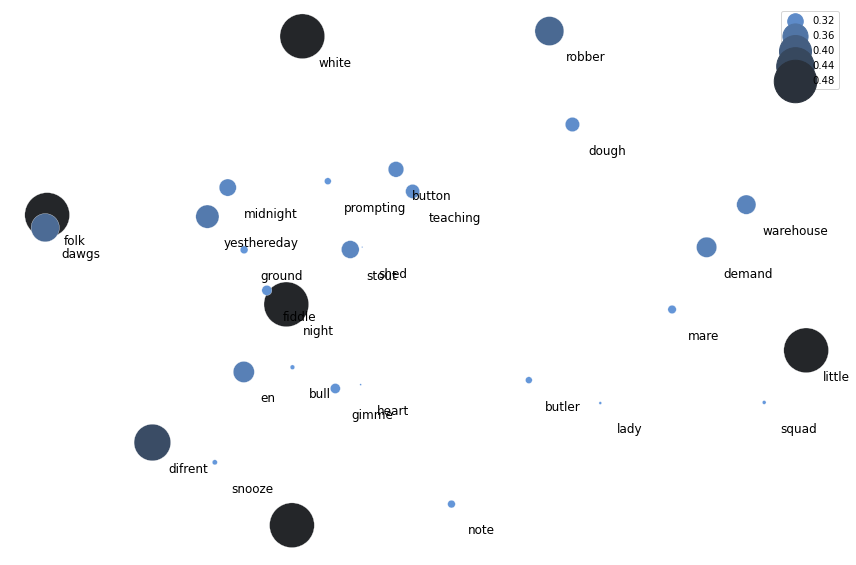

In [85]:
#Let's display the spatial positioning of the output of the word2vec for the words in TF-IDF
#['white','slave','nigger','church']
similar_words = []
similar_vals = []

words=[s.strip() for s in topic_models_output[0][0].split(',')]

for word in words:
    similar_words.append(word)
    similar_vals.append(.5)
    top_5_sim = w2v_model.wv.most_similar(positive=word)[:5]
    for w in top_5_sim:
        similar_words.append(w[0])
        similar_vals.append(w[1])
        
words_df = pd.DataFrame({
    'words':similar_words,
    'vals':similar_vals})
display_pca_scatterplot_w2v(w2v_model.wv, words=words_df['words'].values, vals=words_df['vals'].values)

30


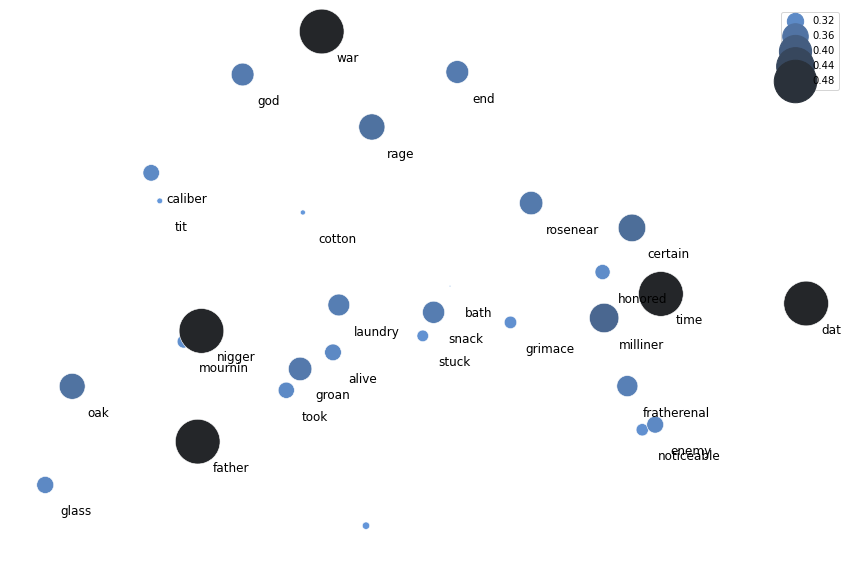

In [86]:
#Let's display the spatial positioning of the output of the word2vec for the words in TF-IDF
#['white','slave','nigger','church']
similar_words = []
similar_vals = []

words=[s.strip() for s in topic_models_output[1][0].split(',')]

for word in words:
    similar_words.append(word)
    similar_vals.append(.5)
    top_5_sim = w2v_model.wv.most_similar(positive=word)[:5]
    for w in top_5_sim:
        similar_words.append(w[0])
        similar_vals.append(w[1])
        
words_df = pd.DataFrame({
    'words':similar_words,
    'vals':similar_vals})
display_pca_scatterplot_w2v(w2v_model.wv, words=words_df['words'].values, vals=words_df['vals'].values)

30


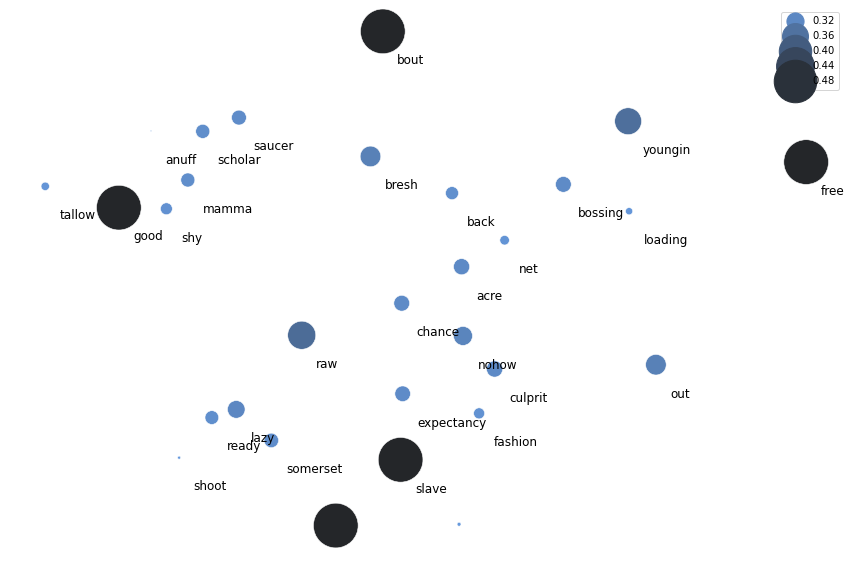

In [87]:
#Let's display the spatial positioning of the output of the word2vec for the words in TF-IDF
#['white','slave','nigger','church']
similar_words = []
similar_vals = []

words=[s.strip() for s in topic_models_output[2][0].split(',')]

for word in words:
    similar_words.append(word)
    similar_vals.append(.5)
    top_5_sim = w2v_model.wv.most_similar(positive=word)[:5]
    for w in top_5_sim:
        similar_words.append(w[0])
        similar_vals.append(w[1])
        
words_df = pd.DataFrame({
    'words':similar_words,
    'vals':similar_vals})
display_pca_scatterplot_w2v(w2v_model.wv, words=words_df['words'].values, vals=words_df['vals'].values)

30


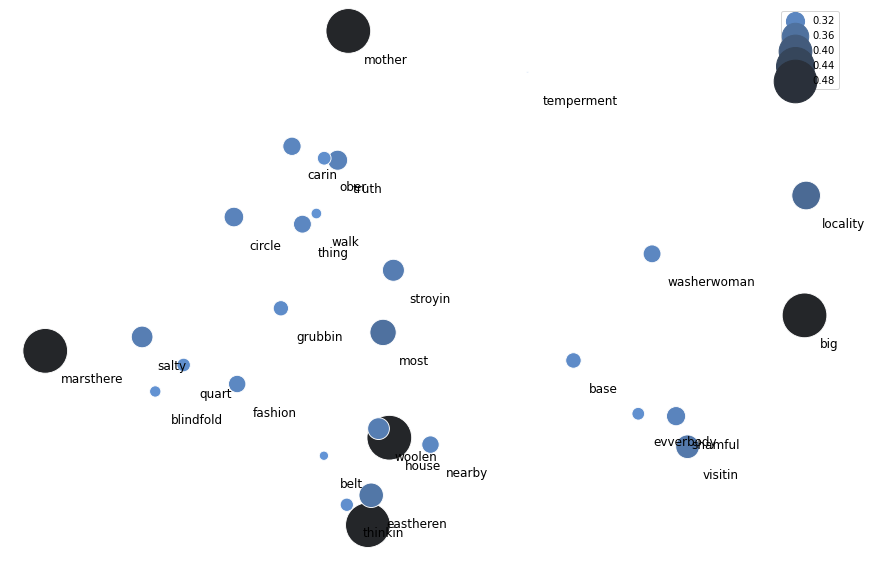

In [88]:
#Let's display the spatial positioning of the output of the word2vec for the words in TF-IDF
#['white','slave','nigger','church']
similar_words = []
similar_vals = []

words=[s.strip() for s in topic_models_output[3][0].split(',')]

for word in words:
    similar_words.append(word)
    similar_vals.append(.5)
    top_5_sim = w2v_model.wv.most_similar(positive=word)[:5]
    for w in top_5_sim:
        similar_words.append(w[0])
        similar_vals.append(w[1])
        
words_df = pd.DataFrame({
    'words':similar_words,
    'vals':similar_vals})
display_pca_scatterplot_w2v(w2v_model.wv, words=words_df['words'].values, vals=words_df['vals'].values)

30


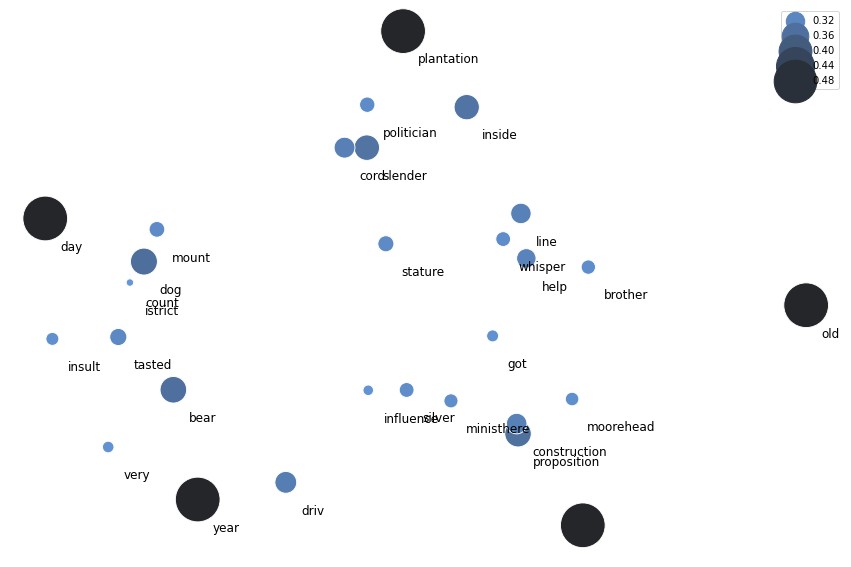

In [89]:
#Let's display the spatial positioning of the output of the word2vec for the words in TF-IDF
#['white','slave','nigger','church']
similar_words = []
similar_vals = []

words=[s.strip() for s in topic_models_output[4][0].split(',')]

for word in words:
    similar_words.append(word)
    similar_vals.append(.5)
    top_5_sim = w2v_model.wv.most_similar(positive=word)[:5]
    for w in top_5_sim:
        similar_words.append(w[0])
        similar_vals.append(w[1])
        
words_df = pd.DataFrame({
    'words':similar_words,
    'vals':similar_vals})
display_pca_scatterplot_w2v(w2v_model.wv, words=words_df['words'].values, vals=words_df['vals'].values)

**Comment**: Here I am using the output of my topic model analysis as my input to word2vec, that for each topic is analyzing the top 7 similar words. These results greatly help in answering initial research question, and they are observable graphically since visual proximity and direction in those plots imply similarity.

### Sum of the counts of the words for each doc2vec output

<AxesSubplot:xlabel='word', ylabel='# appearances'>

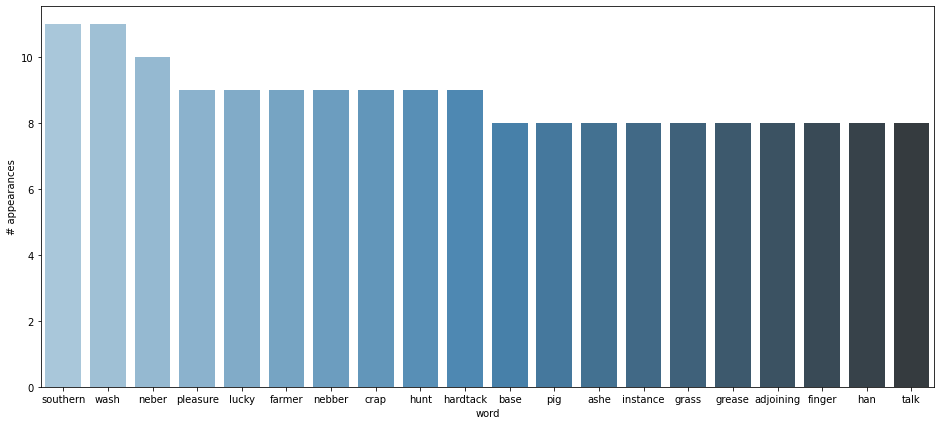

In [90]:
fig, ax = plt.subplots(figsize=(16,7))
sns.barplot(data = pd.DataFrame(counts_d2v.most_common(20)).rename(columns={0:'word',1:'# appearances'}), x='word', y='# appearances', palette='Blues_d',ax=ax)

**Comment**: We can draw information about the environment in which they used to live.

### Correlation of the most characterizing words for each document (doc2vec output) among themselves

In [92]:
corrs = corr_df_d2v.corr()

<AxesSubplot:>

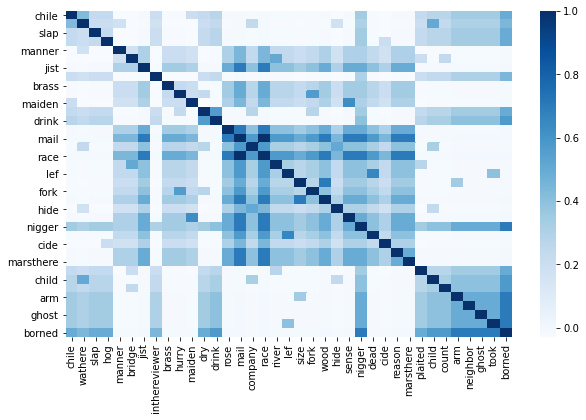

In [93]:
word_of_interest = 'nigger'
interesting_words = [i[1] for i in corrs[corrs>0.3].stack().index.tolist() if i[0]==word_of_interest]
c = corr_df_d2v[interesting_words].corr()
fig,ax = plt.subplots(figsize=(10,6))
sns.heatmap(data=c,ax=ax,cmap="Blues")

<AxesSubplot:>

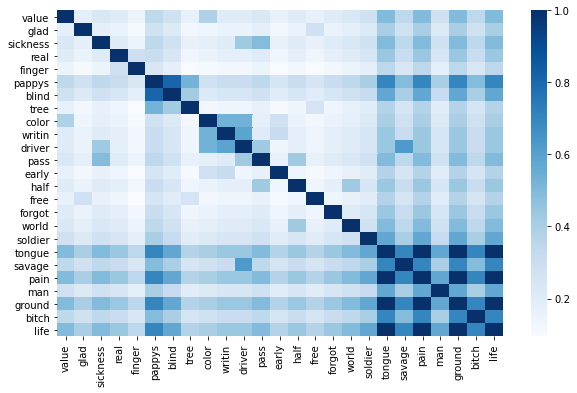

In [94]:
word_of_interest = 'life'
interesting_words = [i[1] for i in corrs[corrs>0.3].stack().index.tolist() if i[0]==word_of_interest]
c = corr_df_d2v[interesting_words].corr()
fig,ax = plt.subplots(figsize=(10,6))
sns.heatmap(data=c,ax=ax,cmap="Blues")

<AxesSubplot:>

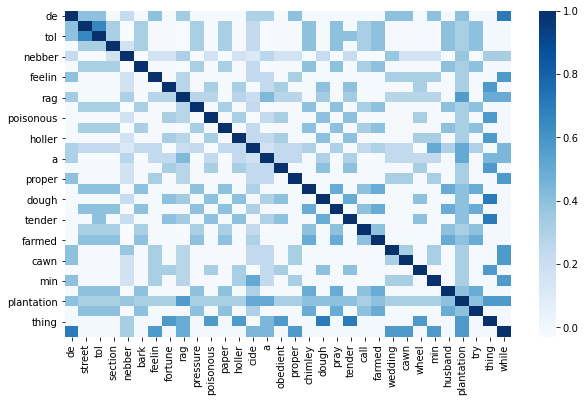

In [95]:
word_of_interest = 'plantation'
interesting_words = [i[1] for i in corrs[corrs>0.3].stack().index.tolist() if i[0]==word_of_interest]
c = corr_df_d2v[interesting_words].corr()
fig,ax = plt.subplots(figsize=(10,6))
sns.heatmap(data=c,ax=ax,cmap="Blues")

<AxesSubplot:>

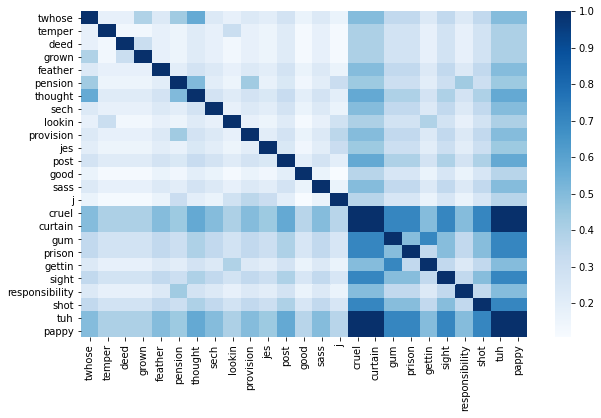

In [96]:
word_of_interest = 'cruel'
interesting_words = [i[1] for i in corrs[corrs>0.3].stack().index.tolist() if i[0]==word_of_interest]
c = corr_df_d2v[interesting_words].corr()
fig,ax = plt.subplots(figsize=(10,6))
sns.heatmap(data=c,ax=ax,cmap="Blues")

**Comment**: Here as well we have interesting results that satisfy the initial research question, such results are displayed graphically as correlation between words amongst the most characterizing ones of each document (doc2vec output).

### Output of the Clustering Algorithm

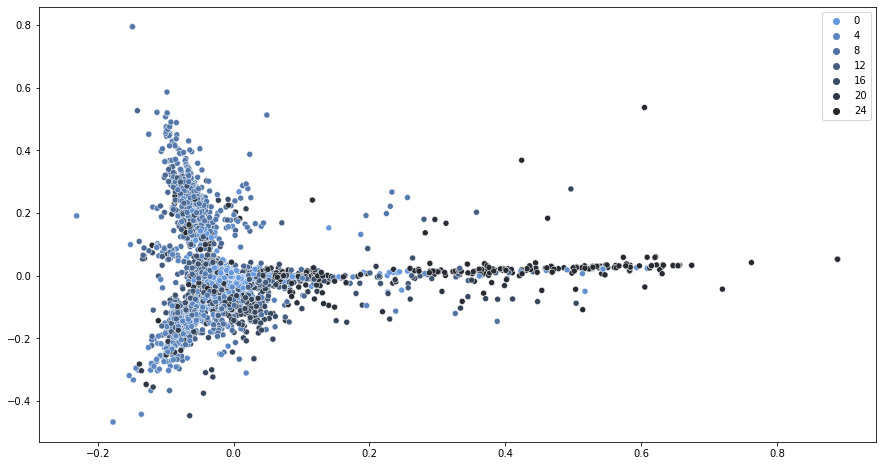

In [97]:
display_pca_scatterplot(X, y)

**Comment**: After having clustered the data and plotted it using PCA for dimensionality reduction, it seems clear that documents do not show a significant difference between each other. And since in this case documents were considered as being phrases of interviews amongst slaves (tagged with the unique slave name), we can assess that there is not a considerable difference amongst them. The latter implies that when accounting for subjective differences in writing style and thoughts, the impressions and memories of the ex-slaves in the interviews do not differ that much from each other, suggesting a similar treatment of the slaves amongst the state of N.C. during segregation.

### Output of the Sentiment Analysis

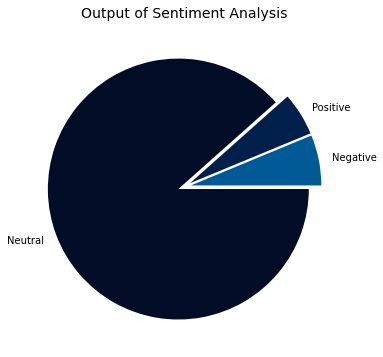

In [98]:
#Using matplotlib
colorscale = [
    '#005a96',
    '#011f4b',
    '#010d26'
]
pie, ax = plt.subplots(figsize=[10,6])
labels = ['Negative','Positive','Neutral']
plt.pie(x=[round(sum(neg),2),round(sum(pos),2),round(sum(neu),2)], 
        explode=[0.05]*3, 
        labels=labels, 
        colors = colorscale,
        pctdistance=0.5)
plt.title("Output of Sentiment Analysis", fontsize=14);


**Comment**: The output of sentiment analysis does not show a distinctive propensity towards a negative sentiment, which is intuitively surprising. Although these are the results, further analysis will be needed since Vader is the only tool available on NLTK for sentiment analysis, yet perhaps not the best tool to be used with such manuscripts (since they are mostly written in dialectal form).